In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from IPython.display import clear_output 
import threading
import imgaug.augmenters as iaa
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
#%matplotlib inline

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
x=splitfolders.ratio("../input/the-kvasir-dataset/kvasir-dataset-v2", output="spiltted",
    seed=0, ratio=(0.7,0.2,0.1)) # default values

# Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
# splitfolders.fixed("../input/the-kvasir-dataset/kvasir-dataset-v2", output="split_data",
#    seed=1337, fixed=(700,200, 100), oversample=False, group_prefix=None, move=False) # default values

Copying files: 8000 files [01:28, 90.81 files/s]


In [5]:
data=ImageDataGenerator(rotation_range = 20, width_shift_range=0.05, shear_range=0.2,
                            zoom_range=0.2, fill_mode='nearest',
                            horizontal_flip=True, vertical_flip=True,
                            rescale=1/255)

  

train_dataset = data.flow_from_directory( directory='./spiltted/train',
                                        target_size=(500,500), batch_size=50, class_mode='categorical', 
                                        shuffle=True)

valid_dataset  =  data.flow_from_directory('./spiltted/val',
                        target_size=(500,500), batch_size=50, class_mode='categorical')
test_dataset = data.flow_from_directory('./spiltted/test',
                        target_size=(500,500),batch_size=10,class_mode='categorical',shuffle=False)

Found 5600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [6]:
test_dataset.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [7]:
# def count(path):
#     x=[]
#     y=os.listdir(path)
#     for dirpath, dirnames, filenames in os.walk(path):
#         n=len(filenames)
#         x.append(n)
#     x=x[1:9]
#     new_dict = dict(zip(y, x))
#     return x,y,new_dict
#     def plot_count(x,y,new_dict):
#         plt.figure(figsize=(15, 6))
#         plt.bar(range(len(x)), list(new_dict.values()), align='center')
#         plt.xticks(range(len(x)), list(new_dict.keys()))
#         plt.title('Distribution of different classes in training datset')
#         plt.show()
    


In [8]:
#     def plot_count(x,y,new_dict):
#         plt.figure(figsize=(15, 6))
#         plt.bar(range(len(x)), list(new_dict.values()), align='center')
#         plt.xticks(range(len(x)), list(new_dict.keys()))
#         plt.title('Distribution of different classes in training datset')
#         plt.show()

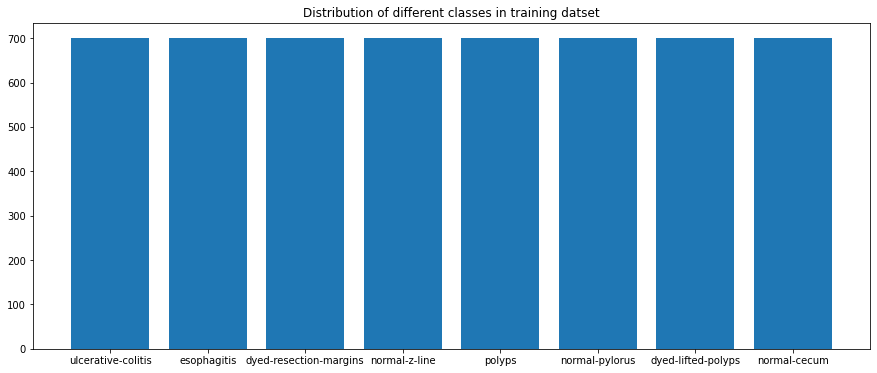

In [9]:
x=[]
path='./spiltted/train'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in training datset')
plt.show()

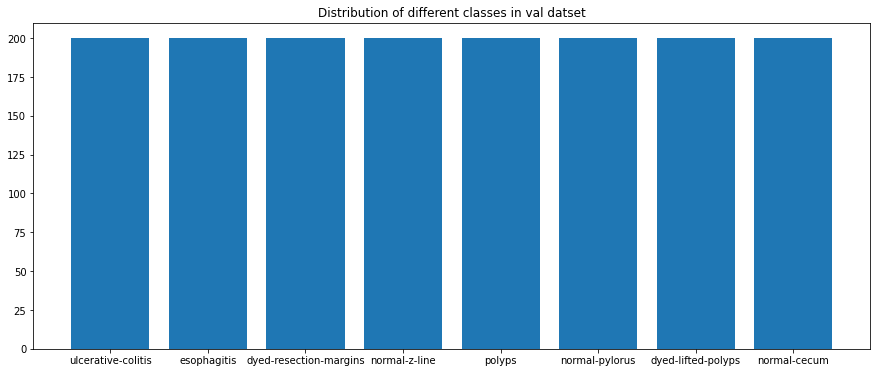

In [10]:
x=[]
path='./spiltted/val'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in val datset')
plt.show()

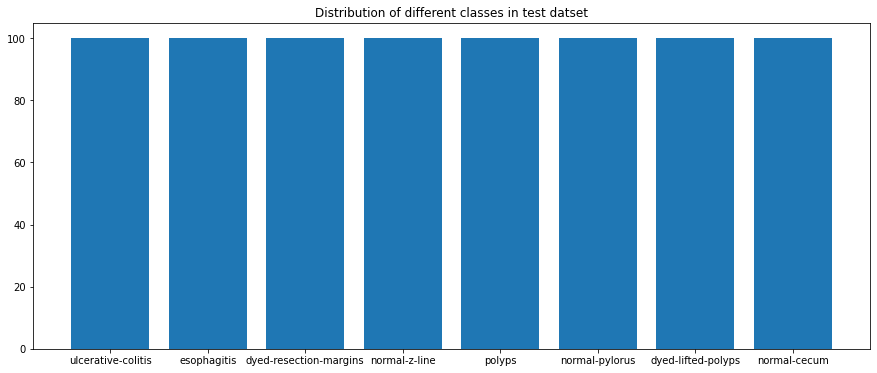

In [11]:
x=[]
path='./spiltted/test'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in test datset')
plt.show()

In [12]:
# train_path='./spiltted/train'
# count(train_path)
# plot_count(x,y,new_dict)
# new_dict = dict(zip(y, x))
# plt.figure(figsize=(15, 6))
# plt.bar(range(len(x)), list(new_dict.values()), align='center')
# plt.xticks(range(len(x)), list(new_dict.keys()))
# plt.title('Distribution of different classes in training datset')
# plt.show()

In [13]:
# val_path='./spiltted/val'
# count(val_path)

# plt.figure(figsize=(15, 6))
# plt.bar(range(len(x)), list(new_dict.values()), align='center')
# plt.xticks(range(len(x)), list(new_dict.keys()))
# plt.title('Distribution of different classes in val datset')
# plt.show()

In [14]:
#@title Model_dict_initialization
import tensorflow_hub
#import tensorflow_addons as tfa
IMAGE_SHAPE = (500,500)

url="https://tfhub.dev/google/imagenet/inception_v3/classification/5"
# url="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
#url="https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
#url="https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
model = tf.keras.Sequential([
      tensorflow_hub.KerasLayer(url,trainable=False, input_shape=IMAGE_SHAPE+(3,)),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dense(250,activation='relu'),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dense(8,activation='softmax')
      ])


#model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["categorical_accuracy", "Precision", "Recall"] )
#model.compile(loss=custom_binary_crossentropy_loss, optimizer='sgd', metrics=['accuracy'],run_eagerly=True )

#model_dict=dict(zip(classes,model_list))

2022-05-11 04:55:31.178028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:55:31.322412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:55:31.323332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:55:31.325122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
dense (Dense)                (None, 500)               501000    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
Total params: 24,505,991
Trainable params: 652,158
Non-trainable params: 23,853,833
_________________________________________________________________


In [16]:
mc = ModelCheckpoint(mode='max', filepath='top-weights-na.h5', monitor='val_categorical_accuracy',save_best_only='True', verbose=1)
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=0)

In [17]:
history=model.fit(train_dataset,epochs=15, validation_data=valid_dataset, callbacks=[mc,es])

2022-05-11 04:55:41.636806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-05-11 04:55:50.689978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


112/112 [==============================] - 508s 4s/step - loss: 0.6848 - categorical_accuracy: 0.7234 - precision: 0.7718 - recall: 0.6632 - val_loss: 0.6091 - val_categorical_accuracy: 0.7425 - val_precision: 0.7581 - val_recall: 0.7169

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74250, saving model to top-weights-na.h5
Epoch 2/15
112/112 [==============================] - 488s 4s/step - loss: 0.4867 - categorical_accuracy: 0.8005 - precision: 0.8167 - recall: 0.7807 - val_loss: 0.4524 - val_categorical_accuracy: 0.8062 - val_precision: 0.8182 - val_recall: 0.7875

Epoch 00002: val_categorical_accuracy improved from 0.74250 to 0.80625, saving model to top-weights-na.h5
Epoch 3/15
112/112 [==============================] - 491s 4s/step - loss: 0.4316 - categorical_accuracy: 0.8204 - precision: 0.8333 - recall: 0.8043 - val_loss: 0.4374 - val_categorical_accuracy: 0.8106 - val_precision: 0.8196 - val_recall: 0.7981

Epoch 00003: val_categorical_accuracy improved from 

In [18]:
test_dataset.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<AxesSubplot:>

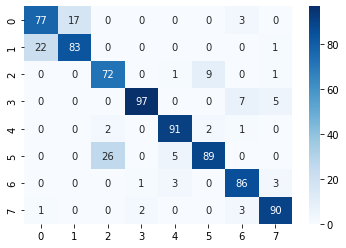

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import numpy as np
Y_pred = model.predict_generator(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)

cm=confusion_matrix(y_pred, test_dataset.classes)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')

In [20]:
# test_dataset = data.flow_from_directory('./spiltted/test',
#                         target_size=(224,224),batch_size=1,class_mode='categorical',shuffle=False)
model.evaluate(test_dataset, verbose=1)

80/80 [==============================] - 53s 664ms/step - loss: 0.3780 - categorical_accuracy: 0.8500 - precision: 0.8542 - recall: 0.8425


[0.37797245383262634,
 0.8500000238418579,
 0.8542459011077881,
 0.8424999713897705]

In [21]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall'])

In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss', marker='o')
    plt.plot( history.history['val_loss'], label='val_loss', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Loss'); plt.ylabel('Loss');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'], label='train_acc', marker='o')
    plt.plot( history.history['val_categorical_accuracy'], label='val_acc', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Accuracy'); plt.ylabel('Accuracy');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_precision(history):
    plt.plot(history.history['precision'], label='train_precision', marker='o')
    plt.plot( history.history['val_precision'], label='val_precision', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Precision'); plt.ylabel('Precision');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_recall(history):
    plt.plot(history.history['recall'], label='train_recall', marker='o')
    plt.plot( history.history['val_recall'], label='val_recall', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Recall'); plt.ylabel('Recall');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()

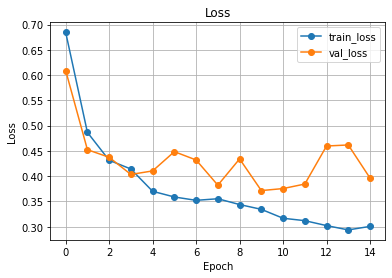

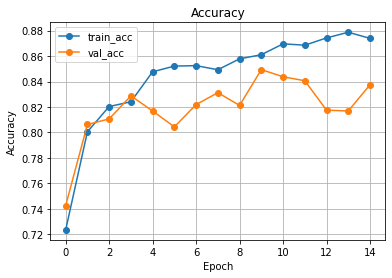

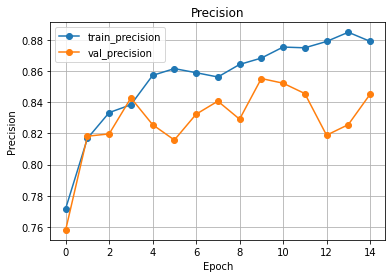

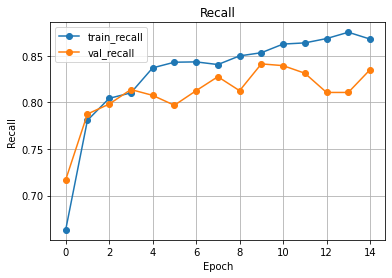

In [23]:
plot_loss(history)
plot_accuracy(history)
plot_precision(history)
plot_recall(history)

In [24]:
os.mkdir('/kaggle/working/mysaved_minor04')

In [25]:
model.save('./mysaved_minor04')

2022-05-11 07:02:31.341664: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
model = keras.models.load_model('/kaggle/working/mysaved_minor04')

In [27]:
acc = model.evaluate(test_dataset, verbose=0)

In [28]:
acc

[0.3616354763507843, 0.8374999761581421, 0.8460559844970703, 0.831250011920929]

In [29]:
import numpy as np
import cv2
# for dirpath, dirnames, filenames in os.walk('./spiltted/test'):
img=cv2.imread("../input/the-kvasir-dataset/kvasir-dataset-v2/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg")
res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
res = np.expand_dims(res, axis=0)
x=np.argmax(model.predict(res))
    
# model.predict(res)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/utils.py:68 return_outputs_and_add_losses
        outputs, losses = fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/utils.py:166 wrap_with_training_arg
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/keras/utils/control_flow_util.py:106 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/smart_cond.py:58 smart_cond
        return false_fn()
    /opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/utils.py:166 <lambda>
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/utils.py:162 replace_training_and_call
        return wrapped_call(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:885 __call__
        result = self._call(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:924 _call
        results = self._stateful_fn(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3038 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3463 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3308 _create_graph_function
        capture_by_value=self._capture_by_value),
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:1007 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:668 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/saved_model/function_deserialization.py:294 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (2 total):
        * Tensor("inputs:0", shape=(None, 224, 224, 3), dtype=float32)
        * False
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 2 option(s):
    
    Option 1:
      Positional arguments (2 total):
        * TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name='inputs')
        * False
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (2 total):
        * TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name='inputs')
        * True
      Keyword arguments: {}


In [ ]:
x

In [ ]:
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)
#     return images

In [ ]:
# import cv2
# import numpy
# import glob
# for dirpath, dirnames, filenames in os.walk('./spiltted/test'):
# #     folders = glob.glob(dirpath)

#     imagenames_list = []
#     for folder in dirpath:
#         for f in glob.glob(dirpath+'/*.jpg'):
#             imagenames_list.append(f)

#     read_images = []        
#     for image in imagenames_list:
#         read_images.append(cv2.imread(image))

In [ ]:
# len(read_images)

In [ ]:
# os.mkdir('/kaggle/working/mysaved_minor')

In [ ]:
# model.save('./mysaved_minor')


In [ ]:
# model = keras.models.load_model('./mysaved')

In [ ]:
# x=[]
# y=os.listdir(path)
# for dirpath, dirnames, filenames in os.walk(path):
#     n=len(filenames)
#     x.append(n)
# x=x[1:9]

In [ ]:
# a=os.listdir('./spiltted/test')
# z=[]
# for dirpath, dirnames, filenames in os.walk("./spiltted/test"):
# #     print(dirpath)
# #     print(dirnames)
# #     print((filenames))
   
#     if 'dyed-lifted-polyps' == dirpath:
#         z.append(0*100)
# #     filename_array=np.array(filenames)
# #     print(filename_array.size )
#         print(z)

In [ ]:
z

In [ ]:
# z=[]
# for i in range(8):
#     z.append([i]*100)

In [ ]:
# Y_test=z

In [ ]:
# y_pred=np.argmax(y_pred)
# y_pred

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# # Y_test=np.argmax(y_test, axis=1)
# y_pred=np.argmax(y_pred)
# cm=confusion_matrix(Y_test,y_pred)
# cm_plot=ConfusionMatrixDisplay(cm,display_labels=['0','1','2','3','4','5','6','7'])
# cm_plot.plot()
# plt.show()